# Exercise 2: 2-dimensional k-nearest neighbors classifier

In [1]:
# Load the data
import pandas as pd

data = pd.read_excel("Rice_Cammeo_Osmancik.xlsx")

In [3]:
# Normalize quantitative columns to mean 0 and standard deviation 1
from sklearn.preprocessing import StandardScaler

cols_to_norm = ["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent"]
data[cols_to_norm] = StandardScaler().fit_transform(data[cols_to_norm])
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.479830,2.004354,2.348547,-0.212943,2.018337,1.499659,-1.152921,Cammeo
1,1.147870,1.125853,0.988390,0.945568,0.410018,1.192918,-0.602079,Cammeo
2,1.135169,1.317214,1.451908,0.253887,1.212956,1.126504,0.405611,Cammeo
3,0.293436,0.115300,0.261439,0.198051,0.239751,0.233857,-0.275351,Cammeo
4,1.166345,1.487053,1.316442,0.523419,0.952221,1.299855,-0.206013,Cammeo


In [4]:
# Reduce the data to two dimensions using PCA
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(data[cols_to_norm])
pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]
data_pca = pd.DataFrame({"pc0": pc0, "pc1": pc1})

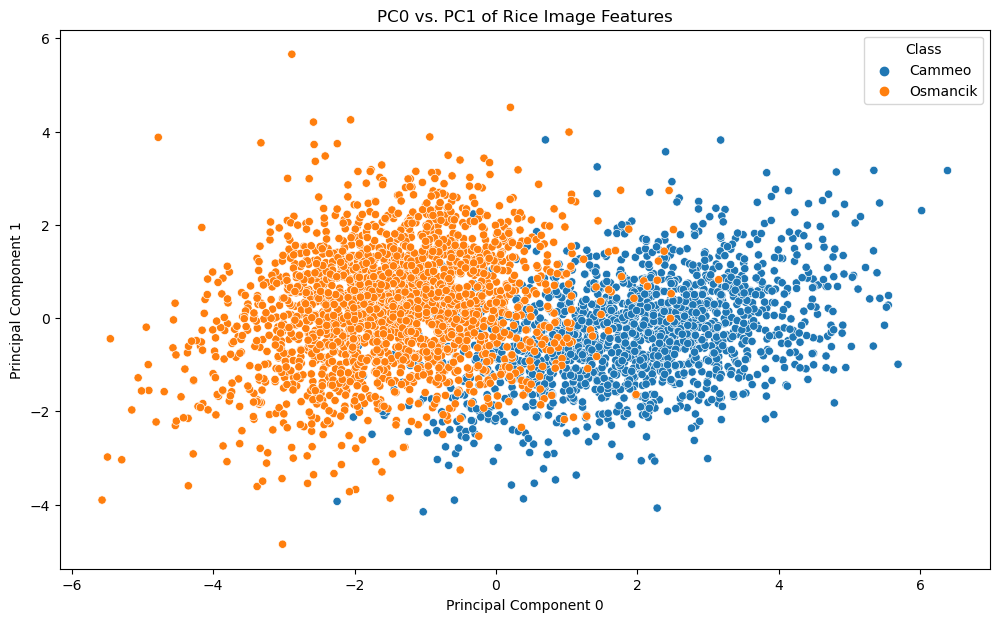

In [5]:
# Generate scatterplot of PC0 vs PC1 for visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,7))
sns.scatterplot(data = data_pca, x = "pc0", y = "pc1", hue = data["Class"])
plt.title("PC0 vs. PC1 of Rice Image Features")
plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.show()

**Interpretation:** The plot shows good (but not perfect) separation of the two classes of rice in the dataset, indicating that the use of PCA to reduce the dimensionality of this dataset will assist in 2-dimensional k-nearest neighbors classification on this dataset. I expect good (but not perfect) classification performance based on this plot.

In [6]:
# Split the data into training and test sets and prepare reduced data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

data = pd.read_excel("Rice_Cammeo_Osmancik.xlsx") # Re-load the data
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Make copies to avoid pandas raising SettingWithCopyWarning
train = train.copy()
test = test.copy()

# Normalize the columns according to their own mean and standard deviation
cols_to_norm = ["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent"]
scaler = StandardScaler()
train.loc[:, cols_to_norm] = scaler.fit_transform(train[cols_to_norm])
test.loc[:, cols_to_norm] = scaler.transform(test[cols_to_norm])  # Note: use the same scaler for test data

# Reduce train and test sets to 2 dimensions using PCA
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train[cols_to_norm])
train_reduced = pd.DataFrame({"x": train_pca[:, 0], "y": train_pca[:, 1], "class": train["Class"]})
test_pca = pca.transform(test[cols_to_norm])
test_reduced = pd.DataFrame({"x": test_pca[:, 0], "y": test_pca[:, 1], "class": test["Class"]})

In [8]:
# Define function for calculating the Euclidean distance
def euclidean_distance(point_1, point_2):
    return ((point_1[0] - point_2[0])**2 + (point_1[1] - point_2[1])**2)**0.5

In [9]:
# 2-D k-nearest neighbors classifier by direct distance measurement (for validation)
import numpy as np

def direct_knn(points, test_point, k):
    distances = [euclidean_distance(test_point, (x, y)) for x, y, _ in points]
    nearest_indices = np.argpartition(distances, k)[:k]
    return [points[i] for i in nearest_indices]

In [10]:
# 2-D k-nearest neighbors classifier by quad tree search
import numpy as np

def knn_quadtree(root, point, k):
    # Find the initial sub-quad tree containing the test point
    subtree = root.small_containing_quadtree(*point)
    while subtree.parent and len(subtree.all_points()) < k:
        subtree = subtree.parent
    
    # Define initial search circle radius
    radius = float("inf")
    if subtree.is_leaf():
        radius = max([euclidean_distance(point, (x, y)) for x, y, _ in subtree.points])

    # Find leaves within the initial search circle radius
    leaves = subtree.leaves_within_distance(*point, radius)

    # Collect all points from these leaves
    all_points = [point for leaf in leaves for point in leaf.all_points()]
    distances = [euclidean_distance(point, (x, y)) for x, y, _ in all_points]

    # Get indices of the k smallest distances
    nearest_indices = np.argpartition(distances, k)[:k]
    nearest_neighbors = [all_points[i] for i in nearest_indices]

    # Return the k nearest neighbors
    return nearest_neighbors

In [11]:
# Store training data ((x, y), class) in self-constructing quad tree
from quadtree import QuadTreeNode

root = QuadTreeNode(x_range=(-5, 5), 
                    y_range=(-5, 5), 
                    points=train_reduced.values.tolist())

In [12]:
# Construct confusion matrices for k=1 and k=5 for both methods
def confusion_matrix(k, class_mapping):
    confusion = np.zeros((2, 2))
    for i in range(len(test_reduced)):
        # Draw a point from the test set
        point = (test_reduced.iloc[i]["x"], test_reduced.iloc[i]["y"])

        # Find the k nearest neighbors to that point
        neighbors = knn_quadtree(root, point, k)
    
        # Predict the class of the point based on the majority class of the neighbors
        classes = [neighbor[2] for neighbor in neighbors]
        prediction = max(set(classes), key=classes.count)
        actual = test_reduced.iloc[i]["class"]

        # Update the confusion matrix
        prediction_idx = class_mapping[prediction]
        actual_idx = class_mapping[actual]
        confusion[prediction_idx][actual_idx] += 1

    return confusion

# Create a class mapping based on test data
class_mapping = {label: index for index, label in enumerate(sorted(set(test_reduced["class"])))}

# Test the classifier for k=1 and k=5
print(f"Confusion matrix for k=1: \n{confusion_matrix(1, class_mapping)}")
print(f"Confusion matrix for k=5: \n{confusion_matrix(5, class_mapping)}")

ValueError: kth(=1) out of bounds (1)

**Interpretation:** 